# Google Traces Parser - clusterdata-2011-2

This Python notebook parse the google trace called "clusterdata-2011-2" and create the necessary trace files required to run "cluster-scheduler-simulator".

Usefull links:
<ul>
    <li>
        <a href="https://github.com/google/cluster-data"> GitHub </a>
    </li>
    <li>
        <a href="https://drive.google.com/open?id=0B5g07T_gRDg9Z0lsSTEtTWtpOW8&authuser=0"> Format + Schema Document </a>
    </li>
    <li>
        <a href="https://groups.google.com/forum/#!forum/googleclusterdata-discuss"> Mailing List </a>
    </li>
</ul>
Notes:
<ul>
    <li>
        All resources utilization are normalized as explained in the "Format + Schema Document" in the above link.
        For this reason we will adjust them to real values using the same cell size of the "cluster-scheduler-simulator".
        File "init-cluster-state.log" expect real value of CPU and Memory to calculate the distribution.
    </li>
</ul>

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext 
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql.functions import col

import os
import errno
import itertools
from collections import OrderedDict

def mkdir_p(path):
    path = path.replace(" ", "_")
    dir_path = os.path.dirname(path)
    try:
        os.makedirs(dir_path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dir_path):
            pass
        else:
            raise
    return path

def print_n_elements(N, dictionary):
    i = 0
    for key, value in dictionary.items():
        print("{}: {}".format(key, value))
        if i > N:
            break
        i += 1

In [2]:
# Config values
CLUSTER_INFO = {
    "mem_machine": 128 * (1024**3),
    "cpu_machine": 32
}

sparkConf = (
    SparkConf()
#     .set("spark.master", os.environ["SPARK_MASTER"])
#     .set("spark.executor.memory", os.environ["SPARK_EXECUTOR_RAM"])
    .set("spark.driver.maxResultSize", 0)
#     .set("spark.driver.memory", "10g")
       )

SIMULATOR_TRACES_OUTPUT_FOLDER = "google-simulator-traces/"
JOB_TRACES_OUTPUT_FOLDER = "job-distribution-traces/"

In [3]:
# Create output folder structure
SIMULATOR_TRACES_OUTPUT_FOLDER = mkdir_p(os.path.join(".", SIMULATOR_TRACES_OUTPUT_FOLDER))
JOB_TRACES_OUTPUT_FOLDER = mkdir_p(os.path.join(SIMULATOR_TRACES_OUTPUT_FOLDER, JOB_TRACES_OUTPUT_FOLDER))

# Restart SparkContext
sc.stop()
sc=SparkContext(conf=sparkConf)
sqlContext = SQLContext(sc)

# Parsing Schemas
schema = StructType([ \
    StructField("file_pattern", StringType(), False), \
    StructField("field_number", IntegerType(), False), \
    StructField("content", StringType(), False), \
    StructField("format", StringType(), False), \
    StructField("mandatory", StringType(), False)])
schema_all = sqlContext.read.format("com.databricks.spark.csv").options(header='true') \
    .load("clusterdata-2011-2/schema.csv", schema=schema)
# Displays the content of the DataFrame
schema_all.show(n=schema_all.count(), truncate=False)
format_type = {
    "INTEGER": DecimalType(32,0),
    "STRING_HASH": StringType(),
    "FLOAT": FloatType(),
    "BOOLEAN": DecimalType(),
    "STRING_HASH_OR_INTEGER": StringType()    
}
schemas = {}
for line in schema_all.orderBy("file_pattern", "field_number").select("*").collect():
    line = line.asDict()
    try:
        if line["file_pattern"] not in schemas:
            schemas[line["file_pattern"]] = []

        schemas[line["file_pattern"]].append(
            StructField(
                line["content"].replace(' ', '_'),
                format_type[line["format"]],
                line["mandatory"] != "YES"
            )
        )
    except KeyError as e:
        print(e)

max_time = pow(2, 63) - 1

+---------------------------------------------+------------+-------------------------------+----------------------+---------+
|file_pattern                                 |field_number|content                        |format                |mandatory|
+---------------------------------------------+------------+-------------------------------+----------------------+---------+
|job_events/part-?????-of-?????.csv.gz        |1           |time                           |INTEGER               |YES      |
|job_events/part-?????-of-?????.csv.gz        |2           |missing info                   |INTEGER               |NO       |
|job_events/part-?????-of-?????.csv.gz        |3           |job ID                         |INTEGER               |YES      |
|job_events/part-?????-of-?????.csv.gz        |4           |event type                     |INTEGER               |YES      |
|job_events/part-?????-of-?????.csv.gz        |5           |user                           |STRING_HASH           |NO 

In [4]:
# Creating DataFrames
dataframes = {}
for file_pattern in schemas:
    dataframes[os.path.dirname(file_pattern)] = sqlContext.read.format("com.databricks.spark.csv") \
        .load("clusterdata-2011-2/" + file_pattern, schema=StructType(schemas[file_pattern]))
        

job_events = dataframes["job_events"]
#job_events.show(truncate=False)

task_events = dataframes["task_events"]
#task_events.show(truncate=False)

task_usage = dataframes["task_usage"]
#task_usage.show(truncate=False)

machine_events = dataframes["machine_events"]
#machine_events.show(truncate=False)


jobs_submitted = job_events[(job_events.event_type == 0)]
jobs_scheduled = job_events[(job_events.event_type == 1)]
jobs_finished = job_events[job_events.event_type == 4]

jobs_running_before_time_window = job_events[(job_events.event_type == 1) & (job_events.time == 0)]
jobs_submitted_or_finished_in_time_window = job_events[((job_events.event_type == 0) | (job_events.event_type == 4)) & \
                                                       ((job_events.time > 0) & (job_events.time < max_time))]
jobs_in_production = job_events[(job_events.scheduling_class != 0) & (job_events.scheduling_class != 1)]
jobs_not_in_production = job_events[(job_events.scheduling_class == 0) | (job_events.scheduling_class == 1)]

tasks_submitted = task_events[task_events.event_type == 0]
tasks_sumbmitted_in_production = task_events[(task_events.event_type == 0) & (task_events.priority >= 9)]
tasks_in_production = task_events[task_events.priority >= 9]
tasks_not_in_production = task_events[task_events.priority < 9]

## Parsing information for init-cluster-state.log

In [5]:
# Creating variables
finished = {}
production = {}
tasks = {}
resources_per_job = {}

# Caching DataFrames usefull for this section
jobs = jobs_running_before_time_window.select(func.col("job_ID"), func.col("scheduling_class")).cache()

In [6]:
# Getting information about jobs that were running before the time window
print("Information about jobs submitted before the time window:")
print("    Total: {}".format(jobs.count()))

finished = jobs_finished.join(jobs, on="job_ID").select(func.col("job_ID"), func.col("time")).rdd.collectAsMap()
# print_n_elements(10, finished)
print("    Ended during the trace: {}".format(len(finished)))

production = tasks_sumbmitted_in_production.join(jobs, on="job_ID").groupBy(func.col("job_ID")).count().rdd.collectAsMap()
# print_n_elements(10, production)
print("    Production: {}".format(len(production)))

tasks = tasks_submitted.join(jobs, on="job_ID").groupBy(func.col("job_ID")) \
        .agg(func.countDistinct("task_index").alias("tasks")).where("tasks >= 1").rdd.collectAsMap()
# print_n_elements(10, tasks)
print("    Have at least 1 task: {}".format(len(tasks)))

# Getting information about resources
resources_per_job = task_events.join(jobs, on="job_ID").groupBy(func.col("job_ID"), func.col("task_index")) \
        .agg(func.avg("CPU_request").alias("cpu"),func.avg("memory_request").alias("memory")) \
        .groupBy(func.col("job_ID")).agg(func.max("cpu").alias("cpu"),func.max("memory").alias("memory")) \
        .rdd.map(lambda x: (x[0], {"cpu" : x[1] * CLUSTER_INFO["cpu_machine"], "memory": x[2] * CLUSTER_INFO["mem_machine"]})) \
        .collectAsMap()
# print_n_elements(10, resources_per_job)
print("    With info about resources: {}".format(len(resources_per_job)))

Information about jobs submitted before the time window:
    Total: 3984
    Ended during the trace: 79
    Production: 2525
    Have at least 1 task: 3979
    With info about resources: 3979


In [7]:
# Write init-cluster-state.log
print("Saving results to file...")
job_count = 0
with open(os.path.join(SIMULATOR_TRACES_OUTPUT_FOLDER, "init-cluster-state.log"), "w") as init_cluster_state:
    for job in jobs.collect():
        # === Common Columns ===
        # Column 0: possible values are 11 or 12
        #   "11" - (8 column schema) something that was there at the beginning of timewindow
        #   "12" - (6 column schema) something that was there at beginning of timewindow and ended at [timestamp] (see Column 1)
        # Column 1: timestamp
        # Column 2: unique job ID
        # Column 3: 0 or 1 - prod_job - boolean flag indicating if this job is "production" priority as described in [1]
        # Column 4: 0, 1, 2, or 3 - sched_class - see description of "Scheduling Class" in [1]
        column_0 = 11
        column_1 = 0
        column_2 = job.job_ID
        column_3 = 0
        column_4 = job.scheduling_class
        # === 6 column format ===
        # Column 5: UNSPECIFIED/UNUSED
        #
        # === 8 column format ===
        # Column 5: number of tasks
        # Column 6: aggregate CPU usage of job (in num cores)
        # Column 7: aggregate Ram usage of job (in bytes)
        column_5 = 0
        column_6 = 0
        column_7 = 0
        
        if job.job_ID in production:
            column_3 = 1
        
        if job.job_ID in tasks:
            column_5 = tasks[job.job_ID]
        
        # What's the point in adding a job with 0 tasks to the trace?
        # Also, if we do so we will get an error
        if column_5 == 0:
            continue
        
        if job.job_ID in resources_per_job:
            column_6 = resources_per_job[job.job_ID]["cpu"]
            column_7 = int(resources_per_job[job.job_ID]["memory"])
            
        init_cluster_state.write("{} {} {} {} {} {} {} {}\n".format(
                column_0, column_1, column_2, column_3, column_4, column_5, column_6, column_7))
        
        if job.job_ID in finished:
            column_0 = 12
            column_1 = finished[job.job_ID] 
            init_cluster_state.write("{} {} {} {} {} {}\n".format(
                column_0, column_1, column_2, column_3, column_4, column_5))
        job_count += 1
        
print("Done. Jobs processed: {}".format(job_count))

Saving results to file...
Done. Jobs processed: 3979


In [8]:
# Removing RDDs from memory
jobs.unpersist()

DataFrame[job_ID: decimal(32,0), scheduling_class: decimal(32,0)]

## Parsing information for {interarrival, runtime, csizes}.log

In [9]:
# Creating variables
submitted = {}
scheduled = {}
finished = {}
tasks = {}
production = {}


# Caching DataFrames usefull for this section
jobs = jobs_submitted_or_finished_in_time_window.orderBy(job_events.time) \
        .groupBy(job_events.job_ID).count().where("count = 2").cache()

In [10]:
# Getting information about jobs that ran during the time window
print("Information about jobs that ran during the time window:")
print("    Total: {}".format(jobs.count()))

submitted = jobs_submitted.join(jobs, on="job_ID").orderBy(func.col("time")) \
    .select(func.col("job_ID"), func.col("time"), func.col("scheduling_class")).rdd\
    .map(lambda x: (x[0], {"submitted":x[1], "scheduling_class":x[2]})).collectAsMap()
# print_n_elements(10, submitted)
print("    Submitted: {}".format(len(submitted)))

scheduled = jobs_scheduled.join(jobs, on="job_ID").select(func.col("job_ID"), func.col("time")).rdd.collectAsMap()
# print_n_elements(10, scheduled)
print("    Scheduled: {}".format(len(scheduled)))

finished = jobs_finished.join(jobs, on="job_ID").select(func.col("job_ID"), func.col("time")).rdd.collectAsMap()
# print_n_elements(10, finished)
print("    Finished: {}".format(len(finished)))
      
production = tasks_sumbmitted_in_production.join(jobs, on="job_ID").groupBy(func.col("job_ID")).count().rdd.collectAsMap()
# print_n_elements(10, production)
print("    Production: {}".format(len(production)))

tasks = tasks_submitted.join(jobs, on="job_ID").groupBy(func.col("job_ID")) \
        .agg(func.countDistinct("task_index").alias("tasks")).where("tasks >= 1").rdd.collectAsMap()
# print_n_elements(10, tasks)
print("    Have at least 1 task: {}".format(len(tasks)))

Information about jobs that ran during the time window:
    Total: 385502
    Submitted: 385502
    Scheduled: 385502
    Finished: 385502
    Production: 35838
    Have at least 1 task: 385482


In [11]:
# Write {interarrival_cmb,runtimes_cmb,csizes_cmb}.log
print("Saving results to files...")

interarrival_cmb = open(os.path.join(JOB_TRACES_OUTPUT_FOLDER, "interarrival_cmb.log"), "w")
runtimes_cmb = open(os.path.join(JOB_TRACES_OUTPUT_FOLDER, "runtimes_cmb.log"), "w")
csizes_cmb = open(os.path.join(JOB_TRACES_OUTPUT_FOLDER, "csizes_cmb.log"), "w")

previous_arrival = 0
job_count = 0
for job_ID, _ in sorted(submitted.items(), key=lambda x: x[1]["submitted"], reverse=False):
    # What's the point in adding a job with 0 tasks to the trace?
    # Also, if we do so we will get an error
    if job_ID not in tasks:
        continue
        
    # === Columns ===
    # Column 0: cluster_name
    # Column 1: assignment policy ("cmb-new" = "CMB_PBB")
    # Column 2: scheduler id, values can be 0 or 1. 0 = batch, service = 1
    # Column 3: depending on which trace file:
    #     interarrival time (seconds since last job arrival)
    #     OR tasks in job
    #     OR job runtime (seconds)
    column_0 = "test"
    column_1 = "cmb-new"
    column_2 = 1 if job_ID in production and \
            (submitted[job_ID]["scheduling_class"] != 0 and submitted[job_ID]["scheduling_class"] != 1) else 0
    
    if submitted[job_ID]["submitted"] - previous_arrival < 0:
        print("Error. Dataset is not ordered by arrival time!")
        break
    interarrival_cmb.write("{} {} {} {} \n".format(column_0, column_1, column_2, \
                                                   (submitted[job_ID]["submitted"] - previous_arrival)/1000000))
    runtimes_cmb.write("{} {} {} {} \n".format(column_0, column_1, column_2, (finished[job_ID] - scheduled[job_ID])/1000000))
    csizes_cmb.write("{} {} {} {} \n".format(column_0, column_1, column_2, tasks[job_ID]))
    
    previous_arrival = submitted[job_ID]["submitted"]
    job_count += 1

interarrival_cmb.close()
runtimes_cmb.close()
csizes_cmb.close()

print("Done. Jobs processed: {}".format(job_count))

Saving results to files...
Done. Jobs processed: 385482


In [12]:
# Removing RDDs from memory
jobs.unpersist()

DataFrame[job_ID: decimal(32,0), count: bigint]

## Parsing information about resources utilization

In [13]:
# Creating variables
cpus_service = {}
cpus_service_without_errors = {}
memory_service = {}
memory_service_without_errors = {}
cpus_batch = {}
cpus_batch_without_errors = {}
memory_batch = {}
memory_batch_without_errors = {}


# Caching DataFrames usefull for this section
resources_requested_service = tasks_in_production.join(jobs_in_production.select(func.col("job_ID")), on="job_ID") \
    .groupBy(func.col("job_ID"), func.col("task_index")) \
    .agg(func.avg("CPU_request").alias("CPU_request"),func.avg("memory_request").alias("memory_request")).cache()
jobs_service = task_usage.select(
    func.col("job_ID"), func.col("task_index"), func.col("CPU_rate"), func.col("canonical_memory_usage")) \
        .join(resources_requested_service, on=["job_ID", "task_index"]) \
        .select(
            ((func.col("CPU_rate")) / ((func.col("CPU_request")))).alias("cpu_used"),
            ((func.col("canonical_memory_usage")) / ((func.col("memory_request")))).alias("memory_used")
        ).cache()
        
resources_requested_batch = tasks_not_in_production.join(jobs_not_in_production.select(func.col("job_ID")), on="job_ID") \
    .groupBy(func.col("job_ID"), func.col("task_index")) \
    .agg(func.avg("CPU_request").alias("CPU_request"),func.avg("memory_request").alias("memory_request")).cache()
jobs_batch = task_usage.select(
    func.col("job_ID"), func.col("task_index"), func.col("CPU_rate"), func.col("canonical_memory_usage")) \
        .join(resources_requested_batch, on=["job_ID", "task_index"]) \
        .select(
            ((func.col("CPU_rate")) / ((func.col("CPU_request")))).alias("cpu_used"),
            ((func.col("canonical_memory_usage")) / ((func.col("memory_request")))).alias("memory_used")
        ).cache()

In [14]:
# Getting information about the resources utilization (CPU and Memory) of service jobs
print("Information about service jobs resources utilization (CPU and Memory):")

cpus_service = jobs_service[func.col("cpu_used") >= 0].groupBy(func.col("cpu_used")).count() \
    .orderBy(func.col("cpu_used")).rdd.map(lambda x: x).collect()
print("    CPU points: {}".format(len(cpus_service)))

cpus_service_without_errors = jobs_service[(func.col("cpu_used") >= 0) & (func.col("cpu_used") <= 1)] \
    .groupBy(func.col("cpu_used")).count() \
    .orderBy(func.col("cpu_used")).rdd.map(lambda x: x).collect()
print("    CPU points with values 0 >= X <= 1: {}".format(len(cpus_service_without_errors)))

memory_service = jobs_service[func.col("memory_used") >= 0].groupBy(func.col("memory_used")).count() \
    .orderBy(func.col("memory_used")).rdd.map(lambda x: x).collect()
print("    Memory points: {}".format(len(memory_service)))

memory_service_without_errors = jobs_service[(func.col("memory_used") >= 0) & (func.col("memory_used") <= 1)] \
    .groupBy(func.col("memory_used")).count() \
    .orderBy(func.col("memory_used")).rdd.map(lambda x: x).collect()
print("    Memory points with values 0 >= X <= 1: {}".format(len(memory_service_without_errors)))

Information about service jobs resources utilization (CPU and Memory):
    CPU points: 1859304
    CPU points with values 0 >= X <= 1: 1716475
    Memory points: 1059375
    Memory points with values 0 >= X <= 1: 1015394


In [15]:
# Getting information about the resources utilization (CPU and Memory) of batch jobs
print("Information about batch jobs resources utilization (CPU and Memory):")

cpus_batch = jobs_batch[func.col("cpu_used") >= 0].groupBy(func.col("cpu_used")).count() \
    .orderBy(func.col("cpu_used")).rdd.map(lambda x: x).collect()
print("    CPU points: {}".format(len(cpus_batch)))

cpus_batch_without_errors = jobs_batch[(func.col("cpu_used") >= 0) & (func.col("cpu_used") <= 1)] \
    .groupBy(func.col("cpu_used")).count() \
    .orderBy(func.col("cpu_used")).rdd.map(lambda x: x).collect()
print("    CPU points with values 0 >= X <= 1: {}".format(len(cpus_batch_without_errors)))

memory_batch = jobs_batch[func.col("memory_used") >= 0].groupBy(func.col("memory_used")).count() \
    .orderBy(func.col("memory_used")).rdd.map(lambda x: x).collect()
print("    Memory points: {}".format(len(memory_batch)))

memory_batch_without_errors = jobs_batch[(func.col("memory_used") >= 0) & (func.col("memory_used") <= 1)] \
    .groupBy(func.col("memory_used")).count() \
    .orderBy(func.col("memory_used")).rdd.map(lambda x: x).collect()
print("    Memory points with values 0 >= X <= 1: {}".format(len(memory_batch_without_errors)))

Information about batch jobs resources utilization (CPU and Memory):
    CPU points: 3388749
    CPU points with values 0 >= X <= 1: 2642126
    Memory points: 2859912
    Memory points with values 0 >= X <= 1: 2780524


In [16]:
# Write {cpu,memory}_slack.log
print("Saving results to file...")

def dump_on_file(data, service, file):    
    job_count = 0
    for key, value in data:
        # === Columns ===
        # Column 0: cluster_name
        # Column 1: assignment policy ("cmb-new" = "CMB_PBB")
        # Column 2: scheduler id, values can be 0 or 1. 0 = batch, service = 1
        # Column 3: cpu or memory slack
        # Column 4: occurrences
        column_0 = "test"
        column_1 = "cmb-new"
        column_2 = 1 if service else 0
        column_3 = key
        column_4 = value

        file.write("{} {} {} {} {} \n".format(column_0, column_1, column_2, column_3, column_4))
        job_count += 1
    
    print("    Dumped {} records on file {}".format(job_count, file.name))

cpu_slack = open(os.path.join(JOB_TRACES_OUTPUT_FOLDER, "cpu_slack.log"), "w")
dump_on_file(cpus_service_without_errors, True, cpu_slack)
dump_on_file(cpus_batch_without_errors, False, cpu_slack)
cpu_slack.close()

memory_slack = open(os.path.join(JOB_TRACES_OUTPUT_FOLDER, "memory_slack.log"), "w")
dump_on_file(memory_service_without_errors, True, memory_slack)
dump_on_file(memory_batch_without_errors, False, memory_slack)
memory_slack.close()

print("Done.")

Saving results to file...
    Dumped 1716475 records on file ./google-simulator-traces/job-distribution-traces/cpu_slack.log
    Dumped 2642126 records on file ./google-simulator-traces/job-distribution-traces/cpu_slack.log
    Dumped 1015394 records on file ./google-simulator-traces/job-distribution-traces/memory_slack.log
    Dumped 2780524 records on file ./google-simulator-traces/job-distribution-traces/memory_slack.log
Done.


In [17]:
# Removing RDDs from memory
resources_requested_service.unpersist()
jobs_service.unpersist()
        
resources_requested_batch.unpersist()
jobs_batch.unpersist()

DataFrame[cpu_used: double, memory_used: double]

Plotting CPU-service
    Max value for CPU-service: Row(cpu_used=689.280029296875, count=1)
    Number of original points: 365963050
    Number of point on X: 3442623
    Number of point on Y: 3442623
Plotting Memory-service
    Max value for Memory-service: Row(memory_used=4.069872365344316, count=2)
    Number of original points: 365963050
    Number of point on X: 1894686
    Number of point on Y: 1894686
Plotting CPU-service-no-errors
    Max value for CPU-service-no-errors: Row(cpu_used=1.0, count=28582)
    Number of original points: 341889660
    Number of point on X: 3183248
    Number of point on Y: 3183248
Plotting Memory-service-no-errors
    Max value for Memory-service-no-errors: Row(memory_used=1.0, count=98652)
    Number of original points: 280848979
    Number of point on X: 1814381
    Number of point on Y: 1814381
Plotting CPU-batch
    Max value for CPU-batch: Row(cpu_used=232431.56831475632, count=1)
    Number of original points: 546148473
    Number of point on X

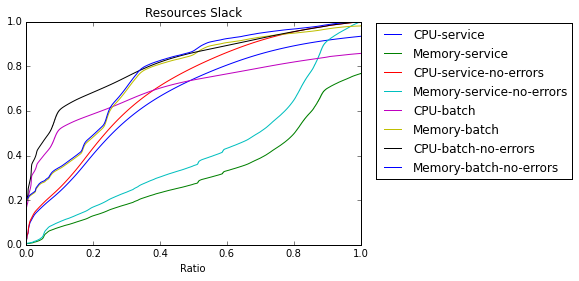

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plt.xscale("log")
plt.xlim([0,1])

datas = [("CPU-service", cpus_service), ("Memory-service", memory_service),
        ("CPU-service-no-errors", cpus_service_without_errors), ("Memory-service-no-errors", memory_service_without_errors),
       ("CPU-batch", cpus_batch), ("Memory-batch", memory_batch),
        ("CPU-batch-no-errors", cpus_batch_without_errors), ("Memory-batch-no-errors", memory_batch_without_errors)]

for key, data in datas:
    print("Plotting {}".format(key))
    print("    Max value for {}: {}".format(key, max(data)))
    total_record = 0
    for value in data:
        total_record += value[1]
    print("    Number of original points: {}".format(total_record))

    x = []
    y = []
    i = 1
    for value in data:
        x.append(value[0])
        y.append(i / float(total_record))
        if value[1] > 1:
            x.append(value[0])
            i += value[1] - 1
            y.append(i / float(total_record))
        i += 1

    print("    Number of point on X: {}".format(len(x)))
    print("    Number of point on Y: {}".format(len(y)))


    plt.plot(np.array(x), np.array(y), label=key)
    
title = plt.title("Resources Slack")
xlabel = plt.xlabel("Ratio")
leg = plt.legend(loc="upper right", bbox_to_anchor=(1.65, 1.02))

plt.savefig("resources_slack.pdf", bbox_extra_artists=(leg, xlabel, title), bbox_inches='tight')